## This script is used to plot the tune shift with amplitude.
- For the tune calculation the NAFF algorithm is used.
- Be careful each time to introduce the configuration file you need along with the file that contains the turn by turn data (from /afs)

In [12]:
import os
import sys
import numpy as np
from math import *
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import NAFFlib as pnf
import json

### Test that you have acces to the /afs directory where your data are stored
If permision denied
- $USERNAME@CERN.CH 
- aklog

In [13]:
ls /afs/cern.ch/work/n/natriant/private

my_tracking_model_htcondor/  simulation_data_2018/  sixdesk/  workspaces/


### Plotting parameters

In [61]:
params = {'legend.fontsize': 30,
          'figure.figsize': (8.5, 6.5),
          'axes.labelsize': 25,
          'axes.titlesize': 25,
          'xtick.labelsize': 25,
          'ytick.labelsize': 25,
          'image.cmap': 'jet',
          'lines.linewidth': 1,
          'lines.markersize': 5,
          'font.family': 'sans-serif'}

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

### Import the parameters of the study

In [15]:
data = {}
with open('./configuration_files/config_octupole.json', "r") as read_file:
        data = json.load(read_file)
my_afs_path = '/afs/cern.ch/work/n/natriant/private/my_tracking_model_htcondor/tracking_data/'

### Define the set of parameters of the study

In [47]:
Delta = 0.1
version = 2
ksi = 0.005
file_name = 'Qx62.775_Qy62.775_detunerx5825.61_detunery0.0_g0.200_delta0.100_betax115.75_betay115.75_particles15000_turns1000_aperture3e-2'
df = pd.read_pickle(my_afs_path+ file_name+ '.pkl')#.format(Delta, version))

### Tune shift with amplitude
- We need to store the data in groups of particles. 
- In our data frames are in groups of turns

In [48]:
x_data = {}
px_data = {}
y_data = {}
py_data = {}
for particle in range(data['study_parameters']['particles']):
    x_data[particle] = []
    px_data[particle] = []
    y_data[particle] = []
    py_data[particle] = []

In [49]:
# 100 turns should be enough
turns = 1000 
for particle in range(data['study_parameters']['particles']):
    #for turn in range(data['study_parameters']['turns']):
    for turn in range(turns):
        x_data[particle].append(df.at[turn,'x'][particle])
        px_data[particle].append(df.at[turn,'px'][particle])
        y_data[particle].append(df.at[turn,'y'][particle])
        py_data[particle].append(df.at[turn,'py'][particle])

### Exclude the particles that are lost, otherwise NAFF crashes.

In [50]:
lost_particles = []
Qx_list = []
Qy_list = []

for particle in range(data['study_parameters']['particles']):
    if np.isnan(x_data[particle]).any() or np.isnan(px_data[particle]).any():
        lost_particles.append(particle)
        print('particle {} lost'.format(particle))
    else:        
        signal_x = x_data[particle]  
        signal_y = y_data[particle] 

        Qx_list.append(pnf.get_tune(np.array(signal_x)))
        Qy_list.append(pnf.get_tune(np.array(signal_y)))

### Use normalised coordiantes (same applies for y)
\begin{equation}
x_{N} = \frac{x}{\sqrt{\beta(s)}} \\
px_{N} = px \cdot \sqrt{\beta(s)}
\end{equation}

### Calculate initial actions Jx (same applies for y)
\begin{equation}
J_x = \frac{x_{N}^2 + px_{N}^2}{2} 
\end{equation}

In [51]:
flag_initial_actions = False
if flag_initial_actions :
    x_norm = df.at[0,'x']/sqrt(data['machine_parameters']['beta_x']) # the index 0 corresponds to turn
    px_norm = df.at[0,'px']*sqrt(data['machine_parameters']['beta_x'])
    Jx_initial = (x_norm**2 + px_norm**2)/2.

    y_norm = df.at[0,'y']/sqrt(data['machine_parameters']['beta_y']) # the index 0 corresponds to turn
    py_norm = df.at[0,'py']*sqrt(data['machine_parameters']['beta_y'])
    Jy_initial = (y_norm**2 + py_norm**2)/2.
    
    print('The maximum initial actions: \nJx ={} \nJy={}'.format(max(Jx_initial), max(Jy_initial)))

### Calculate the average actions for the first 1000 turns

In [52]:
flag_average_actions = True
if flag_average_actions:
    Jx_mean = [] # Here you will save the average actions for each particle over the first and last 1000 turns
    Jx_data = {}
    Jy_mean = [] # Here you will save the average actions for each particle over the first and last 1000 turns
    Jy_data = {}
    for particle in range(data['study_parameters']['particles']):
        Jx_data[particle] = []
        Jx_data[particle] = (np.array(x_data[particle])/sqrt(data['machine_parameters']['beta_x']))**2 + (np.array(px_data[particle])*sqrt(data['machine_parameters']['beta_x']))**2
        Jx_mean.append(np.nanmean(Jx_data[particle]))
               
        
        Jy_data[particle] = []
        Jy_data[particle] = (np.array(y_data[particle])/sqrt(data['machine_parameters']['beta_y']))**2 + (np.array(py_data[particle])*sqrt(data['machine_parameters']['beta_y']))**2
        Jy_mean.append(np.nanmean(Jy_data[particle]))
        
    print('The maximum mean actions: \nJx ={} \nJy={}'.format(max(Jx_mean), max(Jy_mean)))

The maximum mean actions: 
Jx =6.968026454693433e-09 
Jy=5.589690955150607e-09


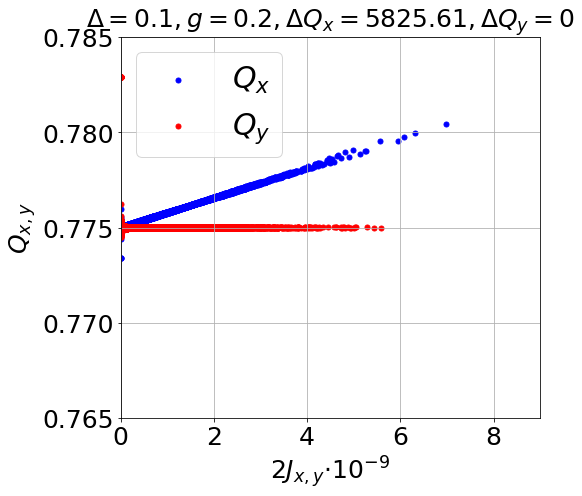

In [62]:
fig, ax = plt.subplots(1,1,figsize=(8,7))

Qx_list_plot = [1-i for i in Qx_list] # 1-i becuase the tune is above 0.5
Qy_list_plot = [1-i for i in Qy_list]

ax.scatter(np.array(Jx_mean)*1e9, Qx_list_plot, c='b', label=r'$Q_x$') 
ax.scatter(np.array(Jy_mean)*1e9, Qy_list_plot, c='r', label=r'$Q_y$') 
ax.set_title(r'$\Delta={}, g={}, \Delta Q_x={}, \Delta Q_y={} $'.format(Delta, 0.2, 5825.61, 0))
ax.set_xlabel(r'$2J_{x,y}$'+r'$\cdot 10^{-9}$')
ax.set_ylabel(r'$Q_{x,y}$')
ax.set_ylim(0.765, 0.785)
ax.set_xlim(0,9)
ax.grid()

plt.legend()
plt.tight_layout()
savefig = False
if savefig:
    plt.savefig('./figures/tune_shift_{}.png'.format(file_name))

### Plot footprint

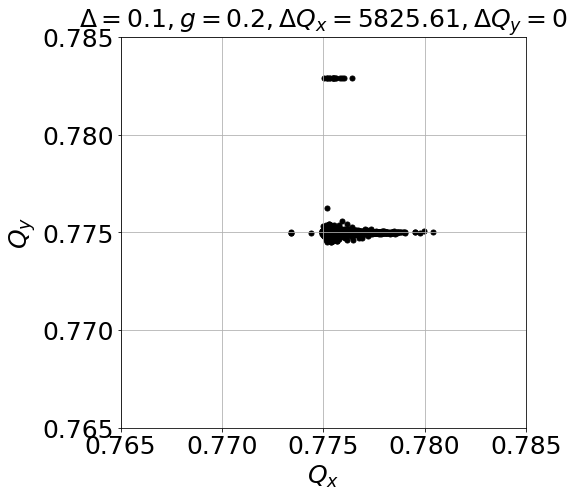

In [63]:
fig, ax = plt.subplots(1,1,figsize=(8,7))

Qx_list_plot = [1-i for i in Qx_list] # 1-i becuase the tune is above 0.5
Qy_list_plot = [1-i for i in Qy_list]

ax.scatter( Qx_list_plot, Qy_list_plot, c='k')
ax.set_title(r'$\Delta={}, g={}, \Delta Q_x={}, \Delta Q_y={} $'.format(Delta, 0.2, 5825.61, 0))
ax.set_xlabel(r'$Q_{x}$')
ax.set_ylabel(r'$Q_{y}$')
ax.set_ylim(0.765, 0.785)
ax.set_xlim(0.765, 0.785)

ax.grid()

plt.tight_layout()
savefig = False
if savefig:
    plt.savefig('./figures/footprint_{}.png'.format(file_name))